# Classifying Damage Level Disaster-Induced Images Via Computer Vision


https://www.overleaf.com/project/662998cb25dcfcdb03e5d57a

Shirley Li, Kofi Mireku, Brent Thorne

Data200S, UC Berkeley MSSE

### Summary:
        This notebook serves as a repository for collecting observations and results.
        It does not represent refinements to models and analyses conducted outside this notebook.

    Model Selection:
        The approach integrates predictive and inferential elements.
        Two model choices:
            Convolutional Neural Network (CNN): Effective for processing grid-like data (e.g., images) and extracting hierarchical features.
            Singular Value Decomposition (SVD) or Principal Component Analysis (PCA): Computationally efficient, providing low-dimensional representations for large, high-dimensional datasets.

    Hyperparameter Tuning:
        The model does not require extensive tuning due to the use of convolutional layers.
        Unlike Support Vector Machines, CNNs perform effectively without extensive hyperparameter adjustments.

    Feature Engineering:
        Image size selection within the interquartile range ensures a balanced and representative sample. (used in initial model, current dev is with weighted bottleneck, w/vgg16)
        Augmentation techniques (flipping, rotation) enhance training data diversity.  (used in initial model, weighted bottleneck for vgg16).
        Resizing images to a common aspect ratio reduces model complexity.

    Cross-Validation:
        Categorical cross-entropy loss function used during cross-validation.
        F1 score is the primary metric for model comparison.
        Precision, recall, and R2 scores provide comprehensive evaluation.

    Bias-Variance Tradeoff and Overfitting:
        Precision, recall, F1 scores, and R2 scores assess bias-variance tradeoff.
        Monitoring training and validation loss helps detect overfitting.
        SVD model uses condition numbers to manage complexity.

    Model Improvement:
        Address label imbalance by augmenting or dropping data based on outcomes.
        Employ k-fold cross-validation for performance estimation on unseen data.
        Use weighted bottleneck and vgg16.
        Explore essemble VGG6, CNN, and SVG. 

    Further Extensions:
        Investigating visualizations of intermediate activations in CNNs.
        Interpreting dimensions of latent space using principal components.
        Exploring Synthetic Minority Oversampling Technique (SMOTE) for data augmentation.


## Import Libraries and Setup Environment

In [1]:
import cv2
import re
import io
import os
import pickle
import zipfile
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from utils import read_files_from_zip, data2pd, show_balance, load_model_data, save_model_data

2024-04-28 12:15:36.900048: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Configure system type
COLAB = False

# Set data and system paths
if COLAB:
  import sys
  from google.colab import drive
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/Colab Notebooks/grad_project'
  data_dir = f'{path}/Data'
  sys.path.insert(0, f'{path}/Source') # for colab to see local libraries
else:
  data_dir = f'../Data'
  path = '.'  

# Set Date Source
data_file = f'{data_dir}/sp24_grad_project_data.zip'
figure_path = f'{path}/../Figures'

In [3]:
%%time

# Pickle out data to speed this up
train_df, test_df = [], []
if (
    os.path.exists(data_dir) 
    & os.path.isfile(f'{data_dir}/train_df.pkl') 
    & os.path.isfile(f'{data_dir}/test_df.pkl')
):
    train_df = pd.read_pickle(f'{data_dir}/train_df.pkl')
    test_df = pd.read_pickle(f'{data_dir}/test_df.pkl')
else:
    # Load Test Images
    test_data_images = read_files_from_zip(data_file, r'(test)_images_([\w-]*)\.npz')
    
    # Load Train Images and Labels
    train_data_images = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_images\.npz')
    train_data_labels = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_labels\.npy')
    
    # Convert to Dataframe
    train_df = data2pd(train_data_images, train_data_labels)
    test_df = data2pd(test_data_images)

    # Pickle DataFrame
    train_df.to_pickle(f'{data_dir}/train_df.pkl')
    test_df.to_pickle(f'{data_dir}/test_df.pkl')
    
    # Clean up
    del(test_data_images)
    del(train_data_images)
    del(train_data_labels)

CPU times: user 382 ms, sys: 336 ms, total: 718 ms
Wall time: 719 ms


## EDA

### Label Distribution

In [4]:
show_balance(train_df)

type       label
fire       0        7204
           3        1064
           1          69
           2          43
flood      0        6734
           1         114
           2          97
           3          59
hurricane  1        5236
           0        2631
           3        1740
           2        1544
Name: count, dtype: int64

label,0,1,2,3
type,,,,
fire,7204,69,43,1064
flood,6734,114,97,59
hurricane,2631,5236,1544,1740


label         0     1     2     3
type                             
fire       7204    69    43  1064
flood      6734   114    97    59
hurricane  2631  5236  1544  1740


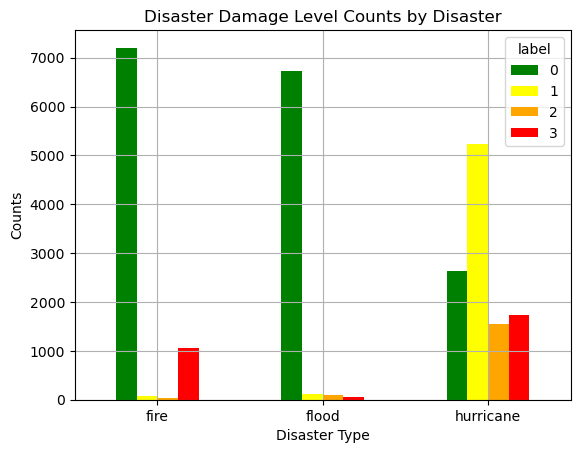

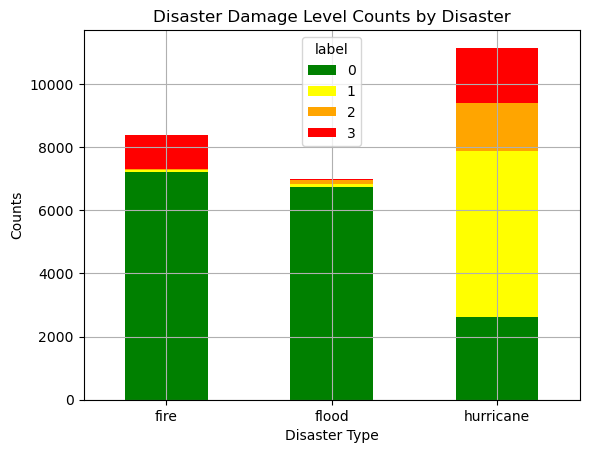

In [5]:
# Label count by disaster type

dd = train_df # in case we want a different sample
label_counts = dd.groupby('type')['label'].value_counts()
#total_counts = label_counts.groupby(level=0).sum()
#label_ratios = label_counts / total_counts

palette = ['red', 'blue', 'green', 'orange']
color_dict = {3: 'red', 0: 'green', 1: 'yellow', 2: 'orange'}

# Pivot the data for plotting
pivot_df = label_counts.unstack(fill_value=0)
display(pivot_df)
print(pivot_df)

# side-by-side
pivot_df.plot(kind='bar',  color=color_dict)
plt.xlabel('Disaster Type')
plt.ylabel('Counts')
plt.title('Disaster Damage Level Counts by Disaster')
#plt.legend(title='Damage Level Label',loc=(1.1,.5))
plt.grid()
plt.xticks(rotation=0)
plt.savefig(f'{figure_path}/eda_label_totals_sidebyside.png', dpi=96)
plt.show()

# slacked
pivot_df.plot(kind='bar', stacked=True, color=color_dict)
plt.xlabel('Disaster Type')
plt.ylabel('Counts')
plt.title('Disaster Damage Level Counts by Disaster')
#plt.legend(title='Damage Level Label')
plt.grid()
plt.xticks(rotation=0)
plt.savefig(f'{figure_path}/eda_label_totals.png', dpi=96)
plt.show()

### Image Size Distribution

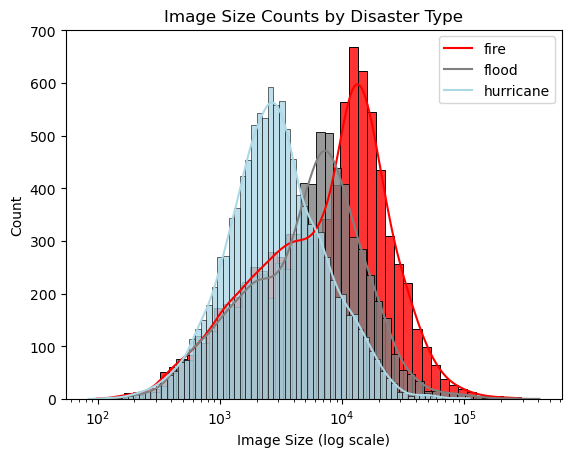

In [6]:
def get_width(row):
    return row.shape[0]

def get_height(row):
    return row.shape[1]

train_df['width'] = train_df['image'].apply(get_width)
train_df['height'] = train_df['image'].apply(get_height)
train_df['image_size'] = train_df['width'] * train_df['height']


df = train_df
alpha = 0.8
sns.histplot(data=df[df['type'] == 'fire'], x='image_size', kde=True, stat="count", label='image size', log_scale=True, color = 'red', alpha=alpha)
sns.histplot(data=df[df['type'] == 'flood'], x='image_size', kde=True, stat="count", label='image size', log_scale=True, color = 'grey', alpha=alpha)
sns.histplot(data=df[df['type'] == 'hurricane'], x='image_size', kde=True, stat="count", label='image size', log_scale=True, color = 'lightblue', alpha=alpha)
plt.legend(labels=['fire','flood','hurricane'])
plt.xlabel("Image Size (log scale)");
plt.title("Image Size Counts by Disaster Type");
plt.savefig(f'{figure_path}/eda_image_size_hist.png', dpi=96)


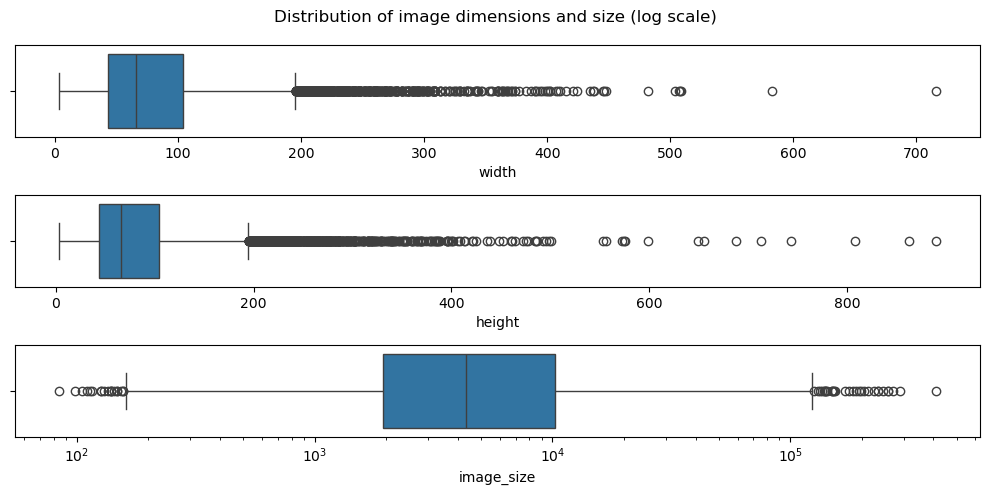

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 5))
sns.boxplot(data=df, x="width", ax=ax[0], log_scale=False);
sns.boxplot(data=df, x="height", ax=ax[1], log_scale=False);
sns.boxplot(data=df, x="image_size", ax=ax[2], log_scale=True);

plt.suptitle('Distribution of image dimensions and size (log scale)')
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(f'{figure_path}/eda_image_size_box.png', dpi=96)

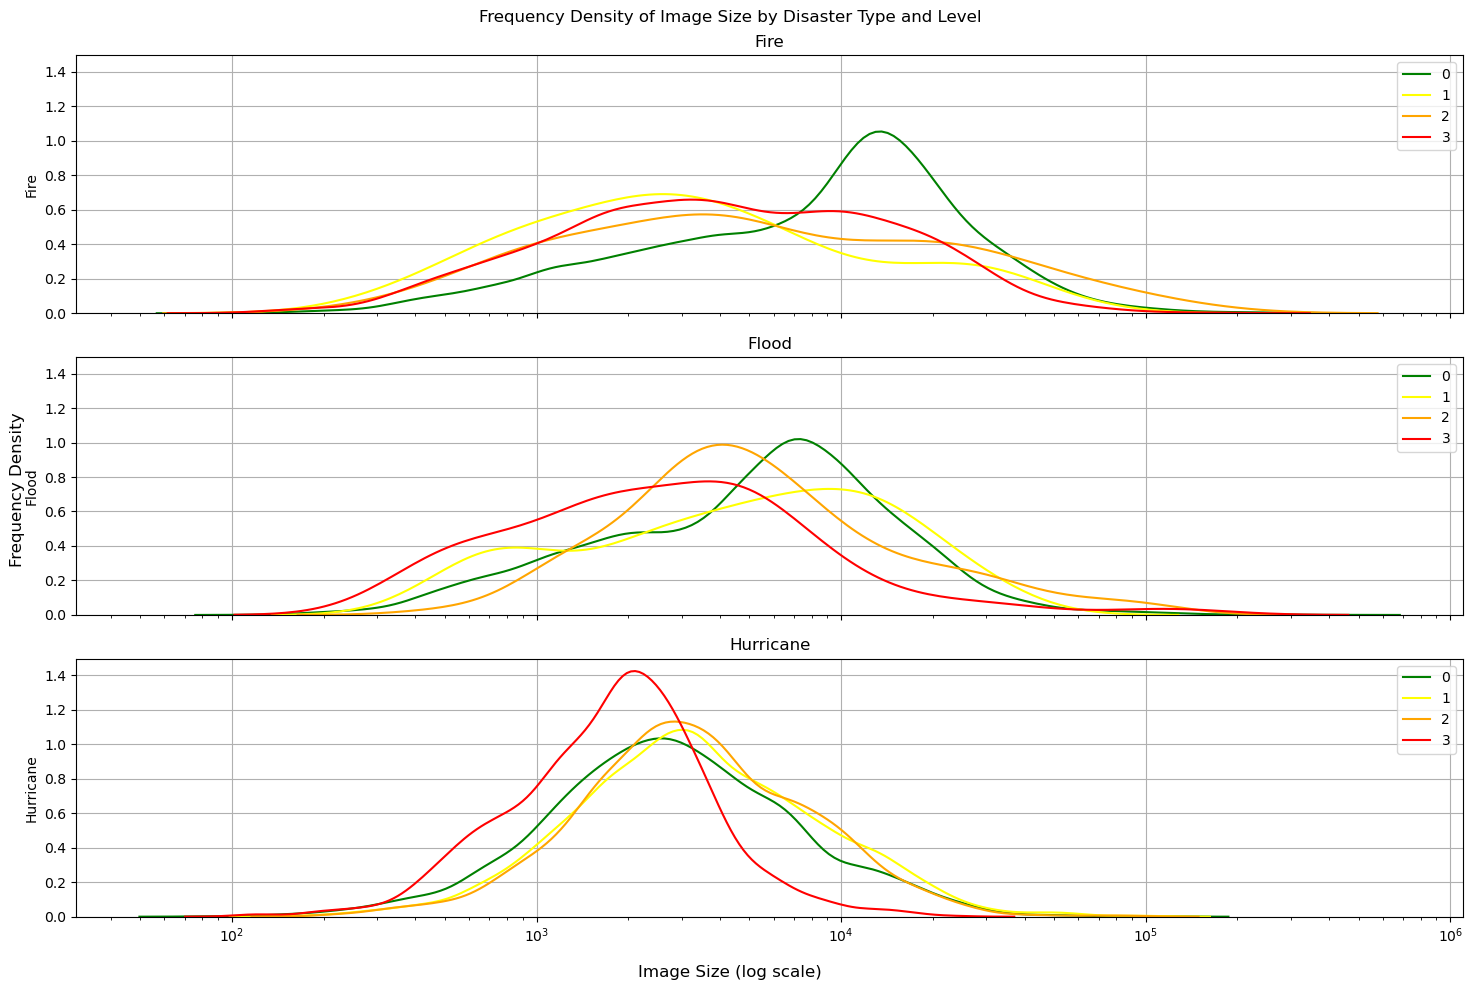

In [8]:
sns.set_palette("bright") # This only set the kde curve color...
color_dict = { 0: 'green', 1: 'yellow', 2: 'orange', 3: 'red'}

alpha = 1
#plt.figure(figsize=(15, 10))
share='all'
fig, ax = plt.subplots(3,1, sharex=share, sharey=share, figsize=(15,10))
for axi, type in enumerate(df['type'].unique()):
    #plt.subplot(3, 1, axi+1, sharex='all', sharey='all')
    for level in range(4):
        #sns.histplot(data=df[(df['type']== type) & (df.label== level)], x='image_size', kde=True, stat="count", label=f'{level}', log_scale=True, color = color_dict[level], alpha=alpha)
        sns.kdeplot(data=df[(df['type']== type) & (df.label== level)], x='image_size', label=f'{level}', log_scale=True, color = color_dict[level], alpha=alpha, bw_adjust=.9, ax=ax[axi])
    ax[axi].legend()
    ax[axi].set_xlabel('');
    ax[axi].set_ylabel(f'{type.title()}')
    ax[axi].set_title(f'{type.title()}')
    ax[axi].grid()
    #plt.gca().set_yscale('log')

fig.supxlabel("Image Size (log scale)")
fig.supylabel('Frequency Density')
plt.suptitle("Frequency Density of Image Size by Disaster Type and Level")
plt.tight_layout()

plt.savefig(f'{figure_path}/eda_image_size_kde_bylevel.png', dpi=96)

## Color Distribution

In [9]:
%%time
def avg_color(img):
    return np.mean(img, axis=(0, 1))
    
df["avg_color"] = df['image'].apply(avg_color)
df["Red"] = df["avg_color"].apply(lambda x: x[0])
df["Green"] = df["avg_color"].apply(lambda x: x[1])
df["Blue"] = df["avg_color"].apply(lambda x: x[2])

melt_df = pd.melt(df, id_vars=["type", "label"], value_vars=["Red", "Green", "Blue"], var_name="color_channel", value_name="color_val")

CPU times: user 4.77 s, sys: 4.02 ms, total: 4.77 s
Wall time: 4.79 s


In [10]:
melt_df.head()

,type,label,color_channel,color_val
0,fire,0,Red,110.409046
1,fire,0,Red,70.399918
2,fire,0,Red,97.319162
3,fire,0,Red,96.571841
4,fire,0,Red,76.582532


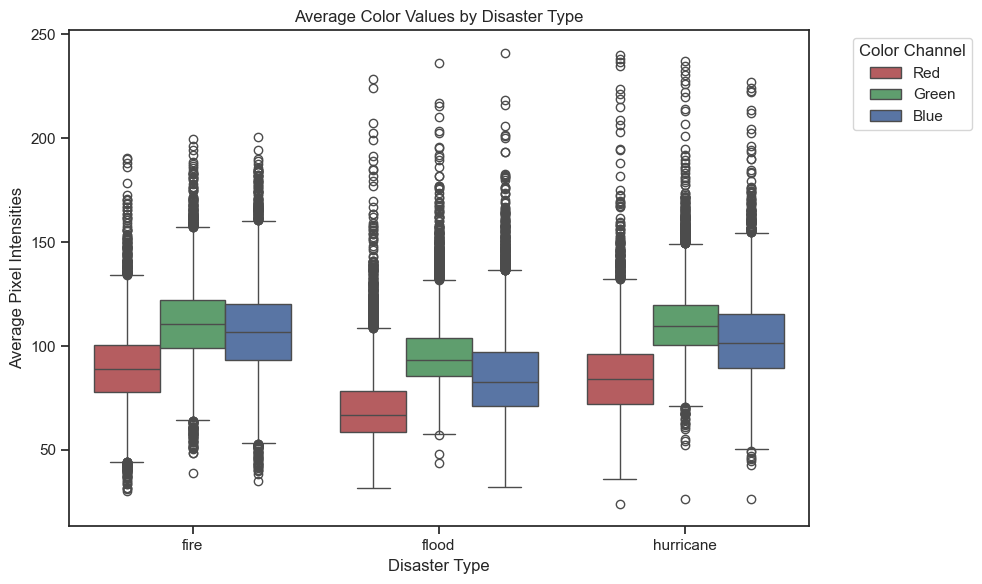

In [11]:
sns.set_theme(style="ticks")
plt.figure(figsize=(10, 6))
sns.boxplot(melt_df, x="type", y="color_val", hue="color_channel", palette=["r", "g", "b"])
plt.xlabel('Disaster Type')
plt.ylabel('Average Pixel Intensities')
plt.title('Average Color Values by Disaster Type')
plt.legend(title='Color Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'{figure_path}/eda_avg_pixel_bar.png', dpi=96)
plt.show()

In [12]:
%%time
df["std_color"] = df["image"].apply(lambda x: np.std(np.array(x), axis=(0, 1)))

df["Red"] = df["std_color"].apply(lambda x: x[0])
df["Green"] = df["std_color"].apply(lambda x: x[1])
df["Blue"] = df["std_color"].apply(lambda x: x[2])

var_df = pd.melt(df, id_vars=["type", "label"], value_vars=["Red", "Green", "Blue"], var_name="color_channel", value_name="std_pixel")

var_df.head()

CPU times: user 11.5 s, sys: 9.31 ms, total: 11.5 s
Wall time: 11.5 s


,type,label,color_channel,std_pixel
0,fire,0,Red,51.128969
1,fire,0,Red,22.793470
2,fire,0,Red,42.198429
3,fire,0,Red,32.584155
4,fire,0,Red,26.867641


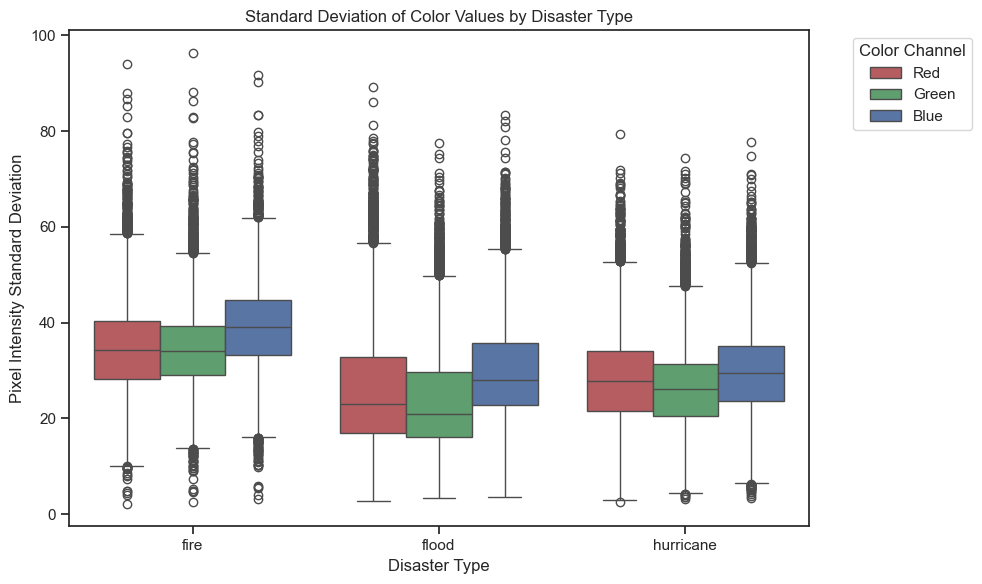

In [13]:
sns.set_theme(style="ticks")
plt.figure(figsize=(10, 6))
sns.boxplot(var_df, x="type", y="std_pixel", hue="color_channel", palette=["r", "g", "b"])
plt.xlabel('Disaster Type')
plt.ylabel('Pixel Intensity Standard Deviation')
plt.title('Standard Deviation of Color Values by Disaster Type')
plt.legend(title='Color Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'{figure_path}/eda_std_pixel_bar.png', dpi=96)
plt.show()

In [14]:
# create "heatmap" of average pixel value for each category
heat_array = []
label = []
dis_type = ["hurricane", "flood", "fire"]
dmg_labels = ["None", "Minor", "Major", "Destroyed"]
for dtype in dis_type:
    for i in range(4):
        type_vals = df[(df["type"] == dtype) & (df["label"] == i)]["avg_color"].sample(n=16).values
        type_vals = np.array([np.array(i) for i in type_vals]).reshape((16, 3))
        heat_array.append(type_vals)
        label.append(dmg_labels[i])
heat_array = np.array(heat_array)
heat_array = heat_array.reshape((12, 16, 3))
print(np.array(heat_array).shape)

(12, 16, 3)


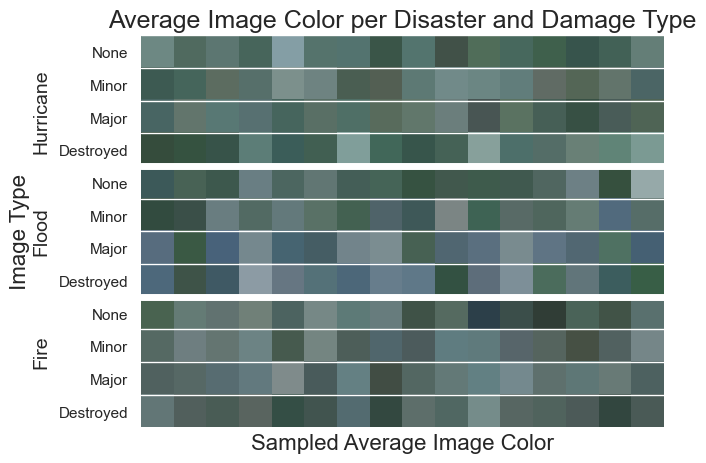

In [15]:
sns.set_style("white")
fig, ax = plt.subplots()
ax.imshow(heat_array.astype(int))

for border_coord in range(12):
    if border_coord == 4 or border_coord == 8:
        plt.axhline(border_coord - 0.5, color='white', linewidth=5)
    else:
        plt.axhline(border_coord - 0.5, color='white', linewidth=1)

ax.axes.xaxis.set_ticks([])
ax.set_yticks(np.arange(12), label)
ax.set_frame_on(False)

plt.xlabel("Sampled Average Image Color", fontsize=16)
plt.title("Average Image Color per Disaster and Damage Type", fontsize=18)
fig.text(-0.05, 0.5, 'Image Type', va='center', rotation='vertical', fontsize=16)
fig.text(-0.015, 0.25, 'Fire', va='center', rotation='vertical', fontsize=14)
fig.text(-0.015, 0.5, 'Flood', va='center', rotation='vertical', fontsize=14)
fig.text(-0.015, 0.75, 'Hurricane', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.savefig(f'{figure_path}/eda_avg_color_swatch.png', dpi=96)
plt.show()

## Feature Engineering, Task A 

In [16]:
# Select Dataset for Disaster Type Classification
train_type_df = train_df[((train_df.type == 'fire') | (train_df.type == 'flood')) ] # & (train_df.label != 0)]
test_type_df = test_df[((test_df.type == 'fire') | (test_df.type == 'flood')) ] # & (test_df.label != 0)]
show_balance(train_type_df)

# Encode labels
def encode_label(type_df):
    type_df = type_df.copy()
    type_df['old_label'] = type_df['label']
    type_df['label'] = type_df[['type','old_label']].apply(
            lambda df: (df['old_label']+1) if df['type']=='fire' else -(df['old_label']), axis=1).astype('int')+ 3 
    return type_df
    
train_type_df = encode_label(train_type_df)

show_balance(train_type_df)
train_type_df.shape, test_type_df.shape

type   label
fire   0        7204
       3        1064
       1          69
       2          43
flood  0        6734
       1         114
       2          97
       3          59
Name: count, dtype: int64

type   label
fire   4        7204
       7        1064
       5          69
       6          43
flood  3        6734
       2         114
       1          97
       0          59
Name: count, dtype: int64

((15384, 13), (3847, 3))

In [17]:
# Verify class labels
unique_labels = np.unique(train_type_df['label']) #+3
#expected_indices = np.arange(7)  # Indices for 7 classes (-3 to 3)
expected_indices = np.arange(8)

if not np.array_equal(unique_labels, expected_indices):
    print("Class labels do not match expected indices. Please verify your labels.")

In [18]:
unique_labels, expected_indices

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([0, 1, 2, 3, 4, 5, 6, 7]))

## Model Task A

see also: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [19]:
train_type_df.columns

Index(['index', 'type', 'image', 'label', 'width', 'height', 'image_size',
       'avg_color', 'Red', 'Green', 'Blue', 'std_color', 'old_label'],
      dtype='object')

In [20]:
from tensorflow.keras import backend
backend.clear_session()  # clear model

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from sklearn.model_selection import train_test_split
#from sklearn.utils import class_weight
from sklearn.utils import compute_class_weight


SIZE = 120 # Set image size

# Load Our DataFrame
df = train_type_df

# Note that 'image' column contains RGB images as numpy arrays
# and 'label' column contains values (-3, -2, -1, 0, 1, 2, 3),
# Nope... [0,1,2,3,4,5,6,7], where >3.5 is fire

# Split data into training and validation sets
m_train_df, m_val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Load VGG16 model with pre-trained weights (excluding top layers)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Extract bottleneck features for training data
def extract_bottleneck_features(dataframe):
    features = []
    for img_array in tqdm(dataframe['image']):
        img_array = tf.image.resize(img_array, (SIZE, SIZE))  # Resize to VGG16 input size
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        bottleneck_feature = vgg16.predict(np.expand_dims(img_array, axis=0), verbose=0)
        features.append(bottleneck_feature.flatten())
    return np.array(features)

train_features, val_features = [],[]
if (
    os.path.exists(data_dir) 
    & os.path.isfile(f'{data_dir}/task_A_train_features.npy')
    & os.path.isfile(f'{data_dir}/task_A_test_features.npy')
    & os.path.isfile(f'{data_dir}/task_A_val_features.npy')
):
    train_features = np.load(f'{data_dir}/task_A_train_features.npy')
    test_features = np.load(f'{data_dir}/task_A_test_features.npy')
    val_features = np.load(f'{data_dir}/task_A_val_features.npy')
else:
    train_features = extract_bottleneck_features(m_train_df)
    test_features = extract_bottleneck_features(test_type_df)
    val_features = extract_bottleneck_features(m_val_df)
    np.save(f'{data_dir}/task_A_train_features.npy', train_features)
    np.save(f'{data_dir}/task_A_test_features.npy', test_features)
    np.save(f'{data_dir}/task_A_val_features.npy', val_features)

# Create a simple fully-connected model
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.01)),
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.0001)),
model.add(Dense(8, activation='softmax'))  # 8 classes 

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights for imbalanced labels
train_classes = m_train_df['label']
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_classes), y=train_classes)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Save the model
model_name = 'task_A_vgg16_model_dropout'
model_0, history_0, notes_0 = load_model_data(model_name, path=data_dir)
if model_0 != None:
    model, model_history, notes = model_0, history_0, notes_0
else:
    # Train the model
    model_history = model.fit(train_features, m_train_df['label'], validation_data=(val_features, m_val_df['label']),
          epochs=10, batch_size=128, class_weight=class_weights_dict)
    # Save, one and done.
    save_model_data(model_name, model, model_history, 'trained on weighted labels', path=data_dir)

../Data/models/task_A_vgg16_model_dropout
../Data/models/task_A_vgg16_model_dropout/history.pkl
Gherkin injested.


In [22]:
# Save model and feature weights
FREEZE = False
if FREEZE:
    model_name = 'task_A_vgg16_model'
    save_model_data(model_name, model, model_history, 'trained on weighted labels', path=data_dir)
    np.save(f'{data_dir}/task_A_train_features.npy', train_features)
    np.save(f'{data_dir}/task_A_test_features.npy', test_features)
    np.save(f'{data_dir}/task_A_val_features.npy', val_features)

#train_features = np.load(f'{data_dir}/train_features.npy')
#val_features = np.load(f'{data_dir}/val_features.npy')
train_features.shape, val_features.shape

((12307, 4608), (3077, 4608))

In [23]:
# Use Custom Activation
def custom_activation(y):
    return np.where(y > 3.5, 1, 0)

## Model Evaluation, Task A


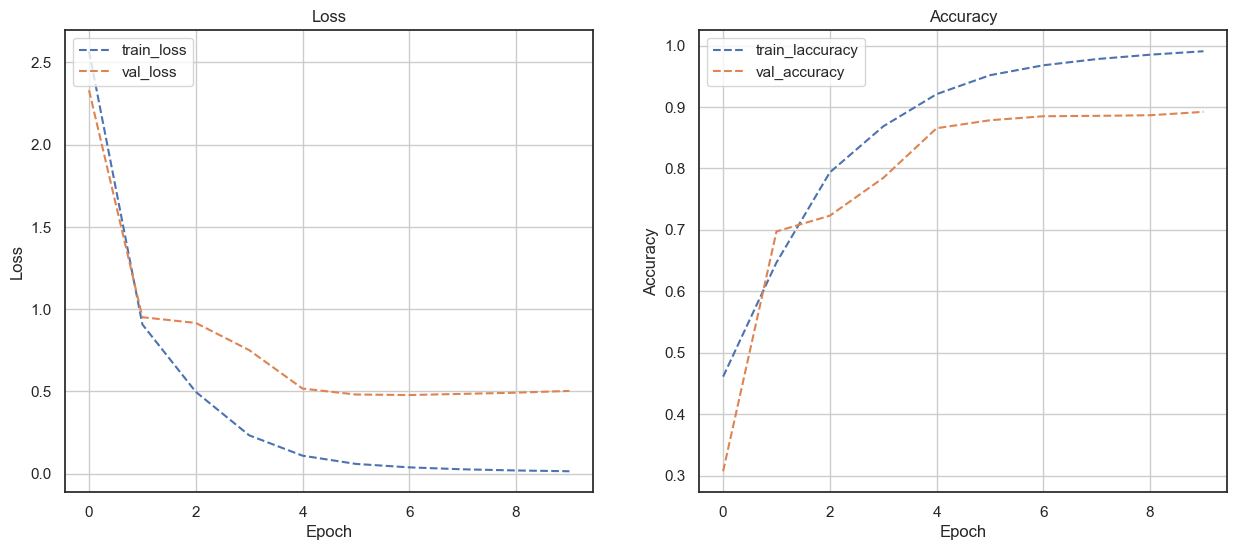

In [24]:
def plot_loss(History):
    history = History.history
    N = len(history["loss"])
    plt.figure(figsize = (15, 6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, N), history["loss"], label = "train_loss", ls = '--')
    plt.plot(np.arange(0, N), history["val_loss"], label = "val_loss", ls = '--')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, N), history["accuracy"], label = "train_laccuracy", ls = '--')
    plt.plot(np.arange(0, N), history["val_accuracy"], label = "val_accuracy", ls = '--')
    #plt.yscale('log')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")
    plt.grid()
    
plot_loss(model_history)

In [25]:
Y_pred = model.predict(val_features)
#Y_pred = model.predict(train_features)
Y_pred = custom_activation(np.argmax(Y_pred, axis=1))
np.sum(Y_pred, axis=0)/len(Y_pred)
Y_actual = custom_activation(m_val_df['label'].to_numpy())
sum(Y_pred==Y_actual) / len(Y_actual)

97/97 [==============================] - 0s 4ms/step


0.9519012024699383

              precision    recall  f1-score   support

           0     0.9510    0.9429    0.9470      1401
           1     0.9526    0.9594    0.9560      1676

    accuracy                         0.9519      3077
   macro avg     0.9518    0.9512    0.9515      3077
weighted avg     0.9519    0.9519    0.9519      3077



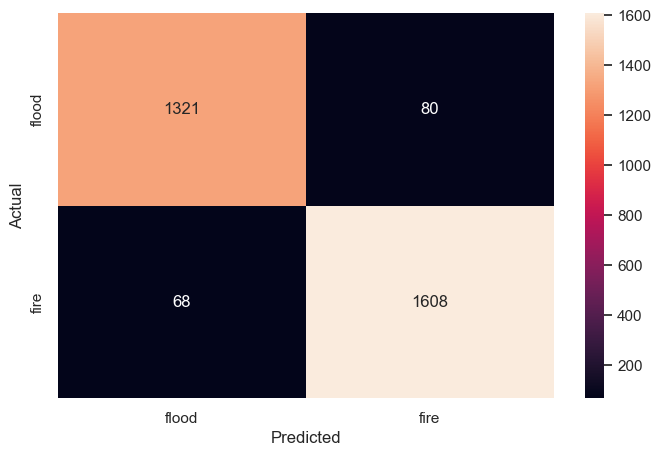

In [26]:
# Evaluate our model based on precision, recall, and f1-score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Printing the classification report
print(classification_report(Y_actual, Y_pred, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(Y_actual, Y_pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f',
          xticklabels = ['flood', 'fire'],
          yticklabels = ['flood', 'fire'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Prediction Task A

In [27]:
# Evaluate the model on test data 
Y_pred = model.predict(test_features)

121/121 [==============================] - 0s 4ms/step


In [28]:
prediction = custom_activation(np.argmax(Y_pred, axis=1))
Y_pred_out = pd.DataFrame(prediction, columns=['pred'])
Y_pred_out.to_csv(f'{data_dir}/test_images_flooding-fire_predictions.csv', index=False)

In [29]:
np.sum(Y_pred_out, axis=0) # 0.9586690927995841

pred    2087
dtype: int64

## Feature Engineering, Task B

In [30]:
# Select Dataset for Disaster Leve Classification
train_level_df = train_df[(train_df.type == 'hurricane') ] 
test_level_df = test_df[(test_df.type == 'hurricane') ] 
show_balance(train_level_df)

type       label
hurricane  1        5236
           0        2631
           3        1740
           2        1544
Name: count, dtype: int64

In [31]:
train_level_df.type.unique()

array(['hurricane'], dtype=object)

In [32]:
train_level_df.columns

Index(['index', 'type', 'image', 'label', 'width', 'height', 'image_size',
       'avg_color', 'Red', 'Green', 'Blue', 'std_color'],
      dtype='object')

In [33]:
backend.clear_session()  # clear model

In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from sklearn.model_selection import train_test_split
#from sklearn.utils import class_weight
from sklearn.utils import compute_class_weight


SIZE = 120 # Set image size

# Load Our DataFrame
df = train_level_df

# Note that 'image' column contains RGB images as numpy arrays
# and 'label' column contains values (-3, -2, -1, 0, 1, 2, 3),
# Nope... [0,1,2,3,4,5,6,7], where >3.5 is fire

# Split data into training and validation sets
m_train_df, m_val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Load VGG16 model with pre-trained weights (excluding top layers)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Extract bottleneck features for training data
def extract_bottleneck_features(dataframe):
    features = []
    for img_array in tqdm(dataframe['image']):
        img_array = tf.image.resize(img_array, (SIZE, SIZE))  # Resize to VGG16 input size
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        bottleneck_feature = vgg16.predict(np.expand_dims(img_array, axis=0), verbose=0)
        features.append(bottleneck_feature.flatten())
    return np.array(features)

train_features, val_features = [],[]
if (
    os.path.exists(data_dir) 
    & os.path.isfile(f'{data_dir}/task_B_train_features.npy') 
    & os.path.isfile(f'{data_dir}/task_B_test_features.npy')
    & os.path.isfile(f'{data_dir}/task_B_val_features.npy')
):
    train_features = np.load(f'{data_dir}/task_B_train_features.npy')
    test_features = np.load(f'{data_dir}/task_B_test_features.npy')
    val_features = np.load(f'{data_dir}/task_B_val_features.npy')
else: #FIXME!!
    m_test_df = test_level_df
    train_features = extract_bottleneck_features(m_train_df)
    test_features = extract_bottleneck_features(m_test_df)
    val_features = extract_bottleneck_features(m_val_df)
    np.save(f'{data_dir}/task_B_train_features.npy', train_features)
    np.save(f'{data_dir}/task_B_test_features.npy', test_features)
    np.save(f'{data_dir}/task_B_val_features.npy', val_features)

# Create a simple fully-connected model
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.01)),
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.0001)),
model.add(Dense(4, activation='softmax'))  # 4 classes 

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights for imbalanced labels
train_classes = m_train_df['label']
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_classes), y=train_classes)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Save the model
model_name = 'task_B_vgg16_model_dropout'
model_0, history_0, notes_0 = load_model_data(model_name, path=data_dir)
if model_0 != None:
    model, model_history, notes = model_0, history_0, notes_0
else:
    # Train the model
    model_history = model.fit(train_features, m_train_df['label'].astype(float), validation_data=(val_features, m_val_df['label'].astype(float)),
          epochs=11, batch_size=128, class_weight=class_weights_dict)

    # Save, one and done.
    save_model_data(model_name, model, model_history, 'trained on weighted labels', path=data_dir)

../Data/models/task_B_vgg16_model_dropout
../Data/models/task_B_vgg16_model_dropout/history.pkl
Gherkin injested.


In [35]:
def custom_activation(y):
    return np.argmax(y, axis=1)

## Model Evaluation, Task B

In [36]:
Y_pred = model.predict(val_features)
Y_pred = custom_activation(Y_pred)
Y_actual =  m_val_df['label'].astype(int).to_numpy()

70/70 [==============================] - 0s 4ms/step


In [37]:
sum(Y_pred==Y_actual) / len(Y_actual)

0.5544598834603317

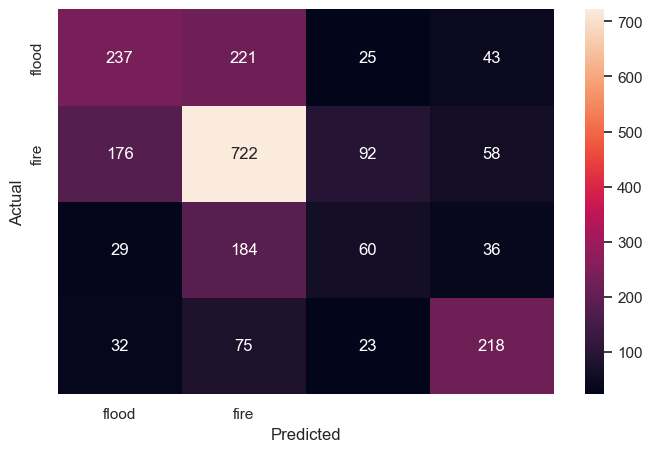

              precision    recall  f1-score   support

           0       0.50      0.45      0.47       526
           1       0.60      0.69      0.64      1048
           2       0.30      0.19      0.24       309
           3       0.61      0.63      0.62       348

    accuracy                           0.55      2231
   macro avg       0.50      0.49      0.49      2231
weighted avg       0.54      0.55      0.54      2231



In [38]:
from sklearn.metrics import classification_report
import numpy as np

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(Y_actual, Y_pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f',
          xticklabels = ['flood', 'fire'],
          yticklabels = ['flood', 'fire'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(classification_report(Y_actual, Y_pred, target_names = ['0', '1', '2', '3']))

# Prediction, Task B

In [39]:
# Make prediction based on test data 
Y_pred = model.predict(test_features)
prediction = custom_activation(Y_pred) # 0.53241 %
Y_pred_out = pd.DataFrame(prediction, columns=['pred'])
Y_pred_out.to_csv(f'{data_dir}/test_images_hurricane-matthew_predictions.csv', index=False)

88/88 [==============================] - 0s 3ms/step
